In [ ]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gc
import os
import random
import multiprocessing
import pickle

from numba import cuda 
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
!pip install tensorflow
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv1D, MaxPooling1D,LSTM
from tensorflow.keras.layers import Dropout, BatchNormalization, LeakyReLU, Activation
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import keras
from keras.models import Sequential, Model, model_from_json,save_model
from keras.layers import Dense, Conv2D, Activation, MaxPool2D, Flatten, Dropout, BatchNormalization,GlobalMaxPooling2D
from keras.utils import np_utils
from keras.preprocessing import image
from keras.callbacks import ModelCheckpoint

     |████████████████████████████████| 462 kB 5.0 MB/s 


In [ ]:
student_data = pd.read_csv("/content/train.csv")
student_data.head()

,id,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,Grade
0,0,GP,F,16,U,GT3,A,0,3,teacher,...,5,4,2,1,0,4,2,8,13,7
1,1,MS,M,17,U,GT3,T,4,0,other,...,4,2,4,2,2,1,28,12,10,12
2,2,MS,F,17,U,LE3,T,1,0,services,...,4,4,2,1,2,2,3,11,9,8
3,3,GP,M,17,R,LE3,T,2,2,health,...,2,4,2,2,2,4,2,16,15,9
4,4,MS,F,14,R,LE3,T,0,1,health,...,3,3,2,2,1,4,0,9,14,8


In [ ]:
student_data.columns

Index(['id', 'school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu',
       'Fedu', 'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime',
       'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery',
       'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc',
       'Walc', 'health', 'absences', 'G1', 'G2', 'Grade'],
      dtype='object')

In [ ]:
training_data = student_data[['address','famsize','Pstatus', 'Medu',
       'Fedu', 'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime',
       'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery',
       'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc',
       'Walc', 'health', 'absences', 'G1', 'G2', 'Grade']].copy()
training_data.head()

,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,Grade
0,U,GT3,A,0,3,teacher,services,home,mother,2,...,5,4,2,1,0,4,2,8,13,7
1,U,GT3,T,4,0,other,services,home,other,1,...,4,2,4,2,2,1,28,12,10,12
2,U,LE3,T,1,0,services,at_home,course,mother,1,...,4,4,2,1,2,2,3,11,9,8
3,R,LE3,T,2,2,health,other,reputation,father,3,...,2,4,2,2,2,4,2,16,15,9
4,R,LE3,T,0,1,health,teacher,reputation,mother,1,...,3,3,2,2,1,4,0,9,14,8


In [ ]:
def encode_to_integer(df):
    le = preprocessing.LabelEncoder()
    for column in df.columns:
        if df.dtypes[column] == 'O':
            df[column] = le.fit_transform(df[column])
    return df

In [ ]:
le = preprocessing.LabelEncoder()
for column in training_data.columns:
    if training_data.dtypes[column] == 'O':
        training_data[column] = le.fit_transform(training_data[column])
training_data.head()   

,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,Grade
0,1,0,0,0,3,4,3,1,1,2,...,5,4,2,1,0,4,2,8,13,7
1,1,0,1,4,0,2,3,1,2,1,...,4,2,4,2,2,1,28,12,10,12
2,1,1,1,1,0,3,0,0,1,1,...,4,4,2,1,2,2,3,11,9,8
3,0,1,1,2,2,1,2,3,0,3,...,2,4,2,2,2,4,2,16,15,9
4,0,1,1,0,1,1,4,3,1,1,...,3,3,2,2,1,4,0,9,14,8


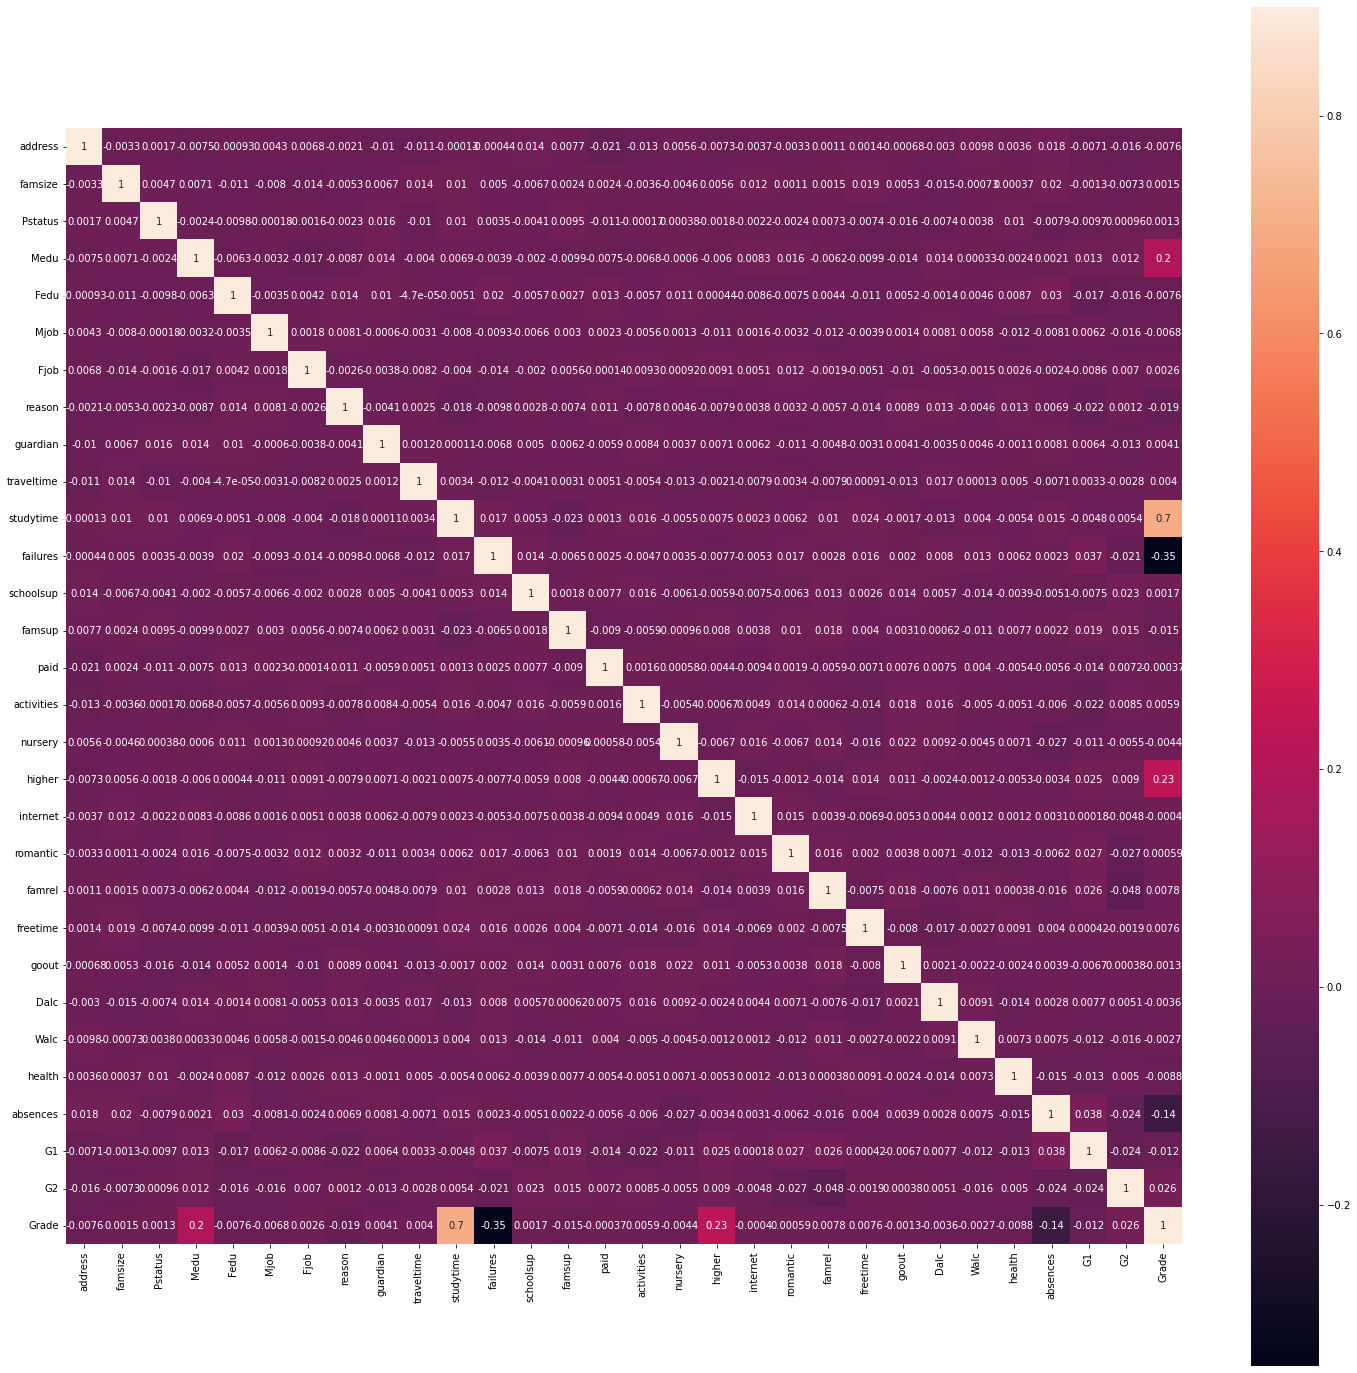

In [ ]:
corrmat = training_data.corr()
plt.subplots(figsize=(25,25))
sns.heatmap(corrmat, vmax=0.9, square=True, annot=True)

In [ ]:
def choose_attributes(df, corr):
    select = []
    for index in corrmat['Grade'].index:
        if(abs(corrmat['Grade'][index]) >= corr):
            select.append(index)
    new_dataset = df[select].copy()
    return new_dataset

In [ ]:
corr_data = choose_attributes(training_data, 0.15)
corr_data.head()

,Medu,studytime,failures,higher,Grade
0,0,2,1,0,7
1,4,4,0,1,12
2,1,2,0,0,8
3,2,1,0,1,9
4,0,0,0,1,8


Medu            AxesSubplot(0.125,0.772143;0.133621x0.107857)
studytime    AxesSubplot(0.285345,0.772143;0.133621x0.107857)
failures      AxesSubplot(0.44569,0.772143;0.133621x0.107857)
higher       AxesSubplot(0.606034,0.772143;0.133621x0.107857)
Grade        AxesSubplot(0.766379,0.772143;0.133621x0.107857)
dtype: object

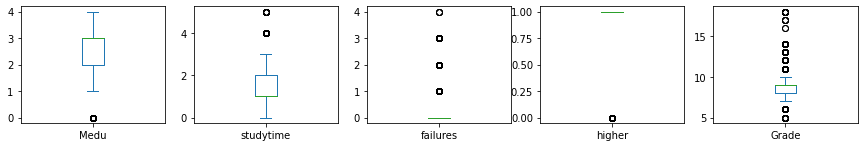

In [ ]:
corr_data.plot(kind='box', figsize=(15,15), subplots=True, layout=(6,5))

In [ ]:
def remove_outliers(df, cols):
    Q1 = df[cols]. quantile(0.25)
    Q3 = df[cols]. quantile(0.75)
    IQR = Q3 - Q1
    df = df[~((df[cols] < (Q1 - 1.5 * IQR)) |(df[cols] > (Q3 + 1.5 * IQR))). any(axis=1)]
    return df

Medu            AxesSubplot(0.125,0.772143;0.133621x0.107857)
studytime    AxesSubplot(0.285345,0.772143;0.133621x0.107857)
failures      AxesSubplot(0.44569,0.772143;0.133621x0.107857)
higher       AxesSubplot(0.606034,0.772143;0.133621x0.107857)
Grade        AxesSubplot(0.766379,0.772143;0.133621x0.107857)
dtype: object

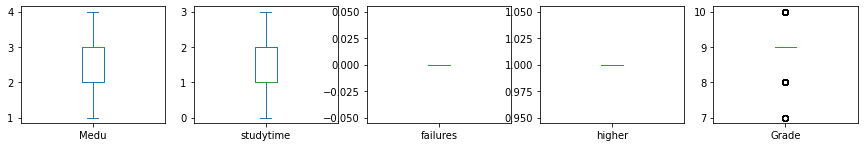

In [ ]:
corr_data_cleaned = remove_outliers(corr_data, corr_data.columns)
corr_data_cleaned.plot(kind='box', figsize=(15,15), subplots=True, layout=(6,5))

In [ ]:
target = corr_data['Grade']
data = corr_data.drop(['Grade'], 1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  


In [ ]:
target_encoded = le.fit_transform(target)
list(set(target_encoded))
le.classes_

array([ 5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 16, 17, 18])

In [ ]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data)

In [18]:
#importing all required packages for data analysis and visualisation
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np
import sklearn
from sklearn import datasets
from sklearn import metrics
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import scale
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import PolynomialFeatures
import seaborn as sns

In [20]:
def evaluate_regression(true, predicted):  
    print('MAE:', metrics.mean_absolute_error(true, predicted))
    print('MSE:', metrics.mean_squared_error(true, predicted))
    print('RMSE:', np.sqrt(metrics.mean_squared_error(true, predicted)))

In [21]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
poly = PolynomialFeatures(degree = 2)
X_poly = poly.fit_transform(scaled_data)
results = lr.fit(X_poly, target)
pred = lr.predict(X_poly)
evaluate_regression(target, pred)

MAE: 0.2969502082073755
MSE: 0.13666192880985253
RMSE: 0.3696781421856755


In [22]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
results = model.fit(scaled_data, target)
pred = model.predict(scaled_data)
evaluate_regression(target, pred)

MAE: 0.5170941849236795
MSE: 0.5091662348726723
RMSE: 0.7135588517232985


In [23]:
from sklearn.linear_model import Ridge
rr = Ridge(alpha=10)
rr.fit(scaled_data, target) 
pred = rr.predict(scaled_data)
evaluate_regression(target, pred)

MAE: 0.5170121279890894
MSE: 0.5091665379573949
RMSE: 0.7135590640986875


In [24]:
from sklearn.svm import LinearSVC
svm_clf = LinearSVC(C=1, loss="hinge", random_state=42)
svm_clf.fit(scaled_data, target)
pred = svm_clf.predict(scaled_data)
evaluate_regression(target, pred)

MAE: 0.5838815789473685
MSE: 1.2756678628389155
RMSE: 1.1294546749820975


In [25]:
from sklearn.tree import DecisionTreeRegressor
clf_gini = DecisionTreeRegressor(min_samples_leaf=40)
clf_gini.fit(scaled_data, target)
pred = clf_gini.predict(scaled_data)
evaluate_regression(target, pred)

MAE: 0.17512552981455798
MSE: 0.11786586134581246
RMSE: 0.3433159788675914


In [26]:
from sklearn.ensemble import RandomForestClassifier
classifier_rf = RandomForestClassifier(random_state=42, n_jobs=-1, max_depth=5,n_estimators=6, oob_score=True)
classifier_rf.fit(scaled_data, target) 
pred = rr.predict(scaled_data)
evaluate_regression(target, pred)

MAE: 0.5170121279890894
MSE: 0.5091665379573949
RMSE: 0.7135590640986875


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:564: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  UserWarning,
